In this notebook you will find the adapted version of the waveform data generator and also its least-squares optimization implementation.


Baseline data: $\sigma_0 = 1.25$ and $\Delta g = 0.5$.

# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import time
from datetime import date
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy.optimize import curve_fit

# Generate Data

In [ ]:
# Parent waves h1, h2, h3
def h1(i):
  return (6 - np.absolute(i - 6)) * np.heaviside((12 - i), 0)

def h2(i):
  return (6 - np.absolute(i - 14)) * np.heaviside((i - 8), 0)

def h3(i):
  return (6 - np.absolute(i - 10)) * np.heaviside((6 - np.absolute(i - 10)), 0)

In [ ]:
def add_noise(X0, sigma0=1.25, delta_g=0.5, mean_g=0.8):

  g = np.random.uniform(mean_g - delta_g, mean_g + delta_g, (X0.shape))
  sigma = g * sigma0

  dX = np.random.normal(0, sigma)
  X = X0 + dX

  # Original waveform
  if delta_g == 0:
    return X, dX[2:-1]

  return X, sigma

In [ ]:
# Visualization
def plot_parent_waves():

  i = np.arange(0, 21)

  fig, ax = plt.subplots(1, 1, figsize=(8, 5))

  ax.plot(i, h1(i), label='$h_i^{(1)}$', color='k')
  ax.plot(i, h2(i), label='$h_i^{(2)}$', color='purple')
  ax.plot(i, h3(i), label='$h_i^{(3)}$', color='darkorange')

  ax.set_xlim(0, 20)
  ax.set_ylim(0, 8)

  ax.axhline(6, color='k', alpha=0.5, linewidth=0.8, linestyle='--')

  ax.set_xticks(ticks=[1, 5, 10, 15, 20])
  ax.set_yticks(ticks=[1, 2, 3, 4, 5, 6])

  ax.set_xlabel('$i$', fontsize=16)

  ax.tick_params(labelsize=14)
  ax.legend(ncol=3, fontsize=16, loc='upper left')

  plt.show()

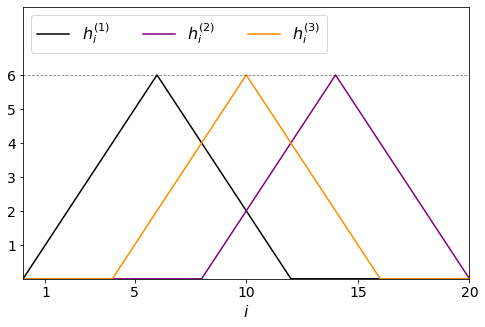

In [ ]:
plot_parent_waves()

In [ ]:
# train or test:
data_name = 'test'

# Choose number of instances per class
m = 10000

# Choose noise parameters
delta_g = 0.5
sigma0 = 1.25

# Choose file name
save = True
if save:
  file_path = 'waveform_modified/datasets/'

In [ ]:
"""
Create waveforms
"""
i = np.arange(0, 21)

# Waveforms without added noise
u_1 = np.random.uniform(low=0, high=1, size=m)
u_2 = np.random.uniform(low=0, high=1, size=m)
u_3 = np.random.uniform(low=0, high=1, size=m)

h_1 = np.tile(h1(i).reshape(len(i), 1), m)
h_2 = np.tile(h2(i).reshape(len(i), 1), m)
h_3 = np.tile(h3(i).reshape(len(i), 1), m)

x1 = (u_1 * h_1 + (1 - u_1) * h_2).T
x2 = (u_2 * h_1 + (1 - u_2) * h_3).T
x3 = (u_3 * h_2 + (1 - u_3) * h_3).T

X0 = np.vstack((x1, x2, x3))

# Add noise to the waveforms
X, sigma = add_noise(X0, sigma0=sigma0, delta_g=delta_g)


"""
Build data set
"""
df = pd.DataFrame(np.hstack((X, sigma)))

# Create labels: 0 for class1, 1 for class2, 2 for class3
y1 = np.tile(np.array([0]), m)
y2 = np.tile(np.array([1]), m)
y3 = np.tile(np.array([2]), m)

y = pd.Series(np.hstack((y1, y2, y3)))

df['type'] = y
df = df.sample(frac=1, random_state=42)

if save:
  df.to_csv(file_path + 'WF_{}_m{}_sig{}_dg{}.csv'.format(data_name,
                                                           int(m*3/1000),
                                                           int(sigma0*10),
                                                           int(delta_g*10)),
            index=False, float_format='%.2f')

# Least Squares

In [ ]:
# Parent waves h1, h2, h3
def h1(i):
  return (6 - np.absolute(i - 6)) * np.heaviside((12 - i), 0)

def h2(i):
  return (6 - np.absolute(i - 14)) * np.heaviside((i - 8), 0)

def h3(i):
  return (6 - np.absolute(i - 10)) * np.heaviside((6 - np.absolute(i - 10)), 0)


# Define models for the waveforms: class1, class2 and class3
def model1(i, u):
  return u * h1(i) + (1 - u) * h2(i)

def model2(i, u):
  return u * h1(i) + (1 - u) * h3(i)

def model3(i, u):
  return u * h2(i) + (1 - u) * h3(i)

In [ ]:
def run_LeastSquares(data):

  """
  Run least squares in the waveform data.
  :param data: waveform curves
  :type data: pandas.DataFrame(shape=(m, 2n + 1))
  :return: values of the chi2 for each waveform type fit, for each instance in
  'data'
  :rtype: numpy.ndarray(shape=(m, 3))
  """

  x = data

  n = 21
  i = np.arange(0, n)

  # Number of degrees of freedom
  dof = n - 1

  # Initial guess for u
  p0 = 0.5

  type1_chisq = []
  type2_chisq = []
  type3_chisq = []


  for j in range(len(x)):

    ydata = np.array(x.iloc[j, :n])
    dy    = np.array(x.iloc[j, n:n*2])

    # fit model1
    popt1, pcov1 = curve_fit(model1, i, ydata, p0=p0, sigma=dy)
    type1_chisq.append(np.sum(((ydata - model1(i, popt1[0]))/dy)**2/dof))

    # fit model2
    popt2, pcov2 = curve_fit(model2, i, ydata, p0=p0, sigma=dy)
    type2_chisq.append(np.sum(((ydata - model2(i, popt2[0]))/dy)**2/dof))

    # fit model3
    popt3, pcov3 = curve_fit(model3, i, ydata, p0=p0, sigma=dy)
    type3_chisq.append(np.sum(((ydata - model3(i, popt3[0]))/dy)**2/dof))


  df = np.vstack((np.array(type1_chisq), np.array(type2_chisq), np.array(type3_chisq))).T

  return df

In [ ]:
# Load data
file_name = 'waveform_modified/datasets/WF_test_m30_sig125_dg5.csv'

data = pd.read_csv(file_name)

In [ ]:
# Least squares return the chisqs of the fits
chisqs = run_LeastSquares(data)

In [ ]:
# The predicted class is the one with the lowest chi2
preds = pd.DataFrame(chisqs).idxmin(axis=1)

# Get true label
true = data['type']

# Compute accuracy
print('Accuracy: ', accuracy_score(true, preds))

# and print the confusion matrix
print('\nConfusion Matrix:\n\n', confusion_matrix(true, preds))
print('\nNormalized Confusion Matrix:\n\n', confusion_matrix(true, preds, normalize='true'))

Accuracy:  0.8693

Confusion Matrix:

 [[8867  575  558]
 [ 835 8615  550]
 [ 840  563 8597]]

Normalized Confusion Matrix:

 [[0.8867 0.0575 0.0558]
 [0.0835 0.8615 0.055 ]
 [0.084  0.0563 0.8597]]


In [ ]:
# Save predictions
#preds.to_csv('least_squares/preds_' + file_name, index=False)